# Défi EGC 2024

### import

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scripts.data_frame_generator import generate_external_time_series,generate_global_time_series, generate_blockchain_by_actor, min_max_norm,std_scale
from scripts.best_correlation import compute_best_correlation,compute_best_correlation_by_col

### Récupérer les séries temporelles extérieures

In [2]:
external_df = generate_external_time_series("timeseries/external.csv")

### Affichage du HashRate et du prix en dollars

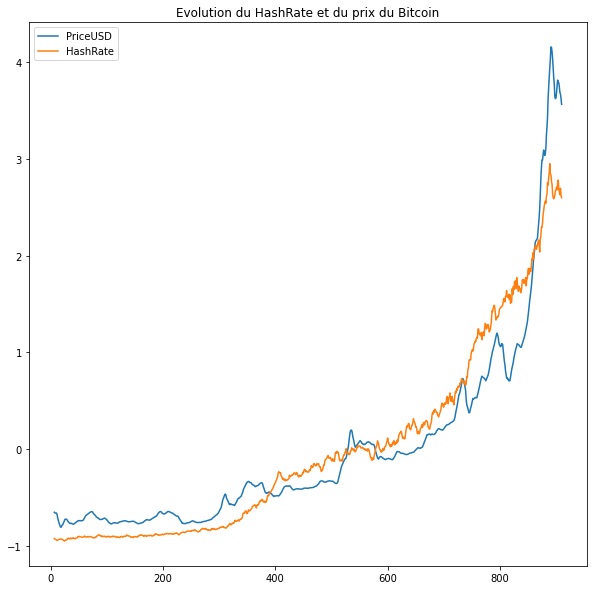

In [3]:
fig, ax1 = plt.subplots( figsize=(10, 10))
# Normalisation des données
std_scaler = StandardScaler()
df_normalized = std_scaler.fit_transform(external_df)
df_normalized = pd.DataFrame(np.array(df_normalized, dtype=np.float64), columns=external_df.columns)
# Lissage et affichage de la courbe
df_normalized.rolling(window=7).mean().plot(ax=ax1)
plt.title("Evolution du HashRate et du prix du Bitcoin")
plt.legend()
plt.show()

#### Evaluation des correlation entre HashRate et le prix du Bitcoin en Dollar

In [4]:
correlation_matrix = external_df.corr()
correlation_matrix

,PriceUSD,HashRate
PriceUSD,1.000000,0.937447
HashRate,0.937447,1.000000


On peut remarquer ici que le score de correlation de Pearson entre le PriceUSD et le HashRate est de 0.93, ce qui signifie que les PriceUSD et Hashrate on une relation linéaire qui est proche.

### Travail sur les 100 principaux acteurs de la blockcahin

In [5]:
block_chain_df = generate_blockchain_by_actor('timeseries/blockchain_by_actor.csv')
column_to_analyze = 'received'
block_chain_df.groupby('identity')[[column_to_analyze]].sum().sort_values(by=column_to_analyze, ascending=False).head()

,received
identity,
Huobi.com,1.313671e+15
ePay.info_CoinJoinMess,1.188925e+15
Bitstamp.net,6.997821e+14
BTC-e.com,5.370579e+14
OKCoin.com,4.589288e+14


In [6]:
short_blochain_df = block_chain_df.copy()


On veut chercher ici à trouver des correlation sur l'évolution de chaque acteurs entre eux à savoir si deux acteurs ont une activité qui évolue de manière similaire comme il a été fait pour l'analyse du HashRate et du cours du Bitcoin.

In [31]:
df_unstacked = short_blochain_df.groupby(['date', 'identity'])[column_to_analyze].mean().unstack()
actor_correlation_matrix = df_unstacked.corr()
np.fill_diagonal(actor_correlation_matrix.values,0)
actor_correlation_matrix.mean()

0.024177819584359002

In [8]:
s = actor_correlation_matrix.stack()
max_index = s.idxmax()[0]
max_col = actor_correlation_matrix.loc[max_index].idxmax()
max_value = actor_correlation_matrix[max_col].loc[max_index]
max_index, max_col

('BTCC.com', 'BtcTrade.com')

On remarque une augmentation du nombre de transactions vers avril 2016 ainsi qu'une baisse vers juillet dans les deux courbes. On notera que le nombre de transaction n'est pas du même ordre de grandeur.

On peut alors se poser la question si l'activité de certains groupes d'acteurs sont corrélées entre elles.

In [32]:
#max_index,max_col, max_value, column_to_analyze =compute_best_correlation(block_chain_df)
column_to_analyze = 'sum_fee'
max_index,max_col, max_value = compute_best_correlation_by_col(block_chain_df,column_to_analyze)
#max_index,max_col, max_value = compute_best_correlation(block_chain_df=block_chain_df)
print(f"La valeur maximale est {max_value} et elle se trouve à l'index  '{max_index}' dans la colonne '{max_col}'")

La valeur maximale est 0.9173973231679152 et elle se trouve à l'index  '107' dans la colonne '69697250'


In [33]:
block_chain_df.columns

Index(['identity', 'received', 'nb_received', 'sum_fee', 'mean_fee_for100',
       'nb_transactions', 'sent', 'self_spent', 'self_spent_estimated',
       'nb_spent', 'spent'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


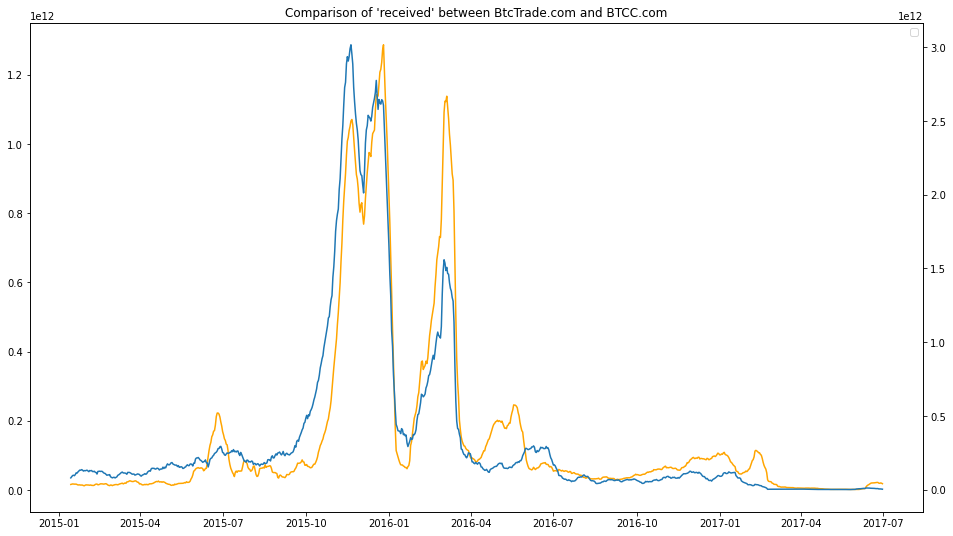

In [35]:
column_to_analyze = 'received'
max_index,max_col, max_value = compute_best_correlation_by_col(block_chain_df,column_to_analyze)
key1,key2 = max_col,max_index
window = 14
f1, ax1 = plt.subplots(figsize=(16,9))
ax2 = ax1.twinx()
temp_df = block_chain_df[block_chain_df['identity'] == key1][column_to_analyze]
ax1.plot(temp_df.rolling(window=window).mean(),color='orange')
temp_df = block_chain_df[block_chain_df['identity'] == key2][column_to_analyze]
ax2.plot(temp_df.rolling(window=window).mean())
plt.title(f"Comparison of '{column_to_analyze}' between {key1} and {key2}")